# Лабораторная работа 1. Классические методы построения рекомендаций.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/main/homeworks/hw_01/rs_hw01.ipynb)

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit. Пожалуйста, посмотрите [документацию](https://benfred.github.io/implicit/api/models/recommender_base.html) и примеры использования на [github](https://github.com/benfred/implicit), чтобы лучше разобраться с форматом входных данных.

Вопросы по заданию можно писать в чат курса. Ссылка на форму для отправки решений будет дана в чате.

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.6 MB/s eta 0:00:00


In [3]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 28.5 MB/s eta 0:00:00


In [4]:
!pip install rs-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 15.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

import implicit
from implicit.als import AlternatingLeastSquares

from copy import deepcopy
from tqdm import tqdm

from implicit.nearest_neighbours import BM25Recommender
import optuna

In [6]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [7]:
from rs_datasets import MovieLens

In [8]:
data = MovieLens("1m")
data.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 8.52MB/s]                            


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [9]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [10]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [11]:
get_log_info(reviews)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


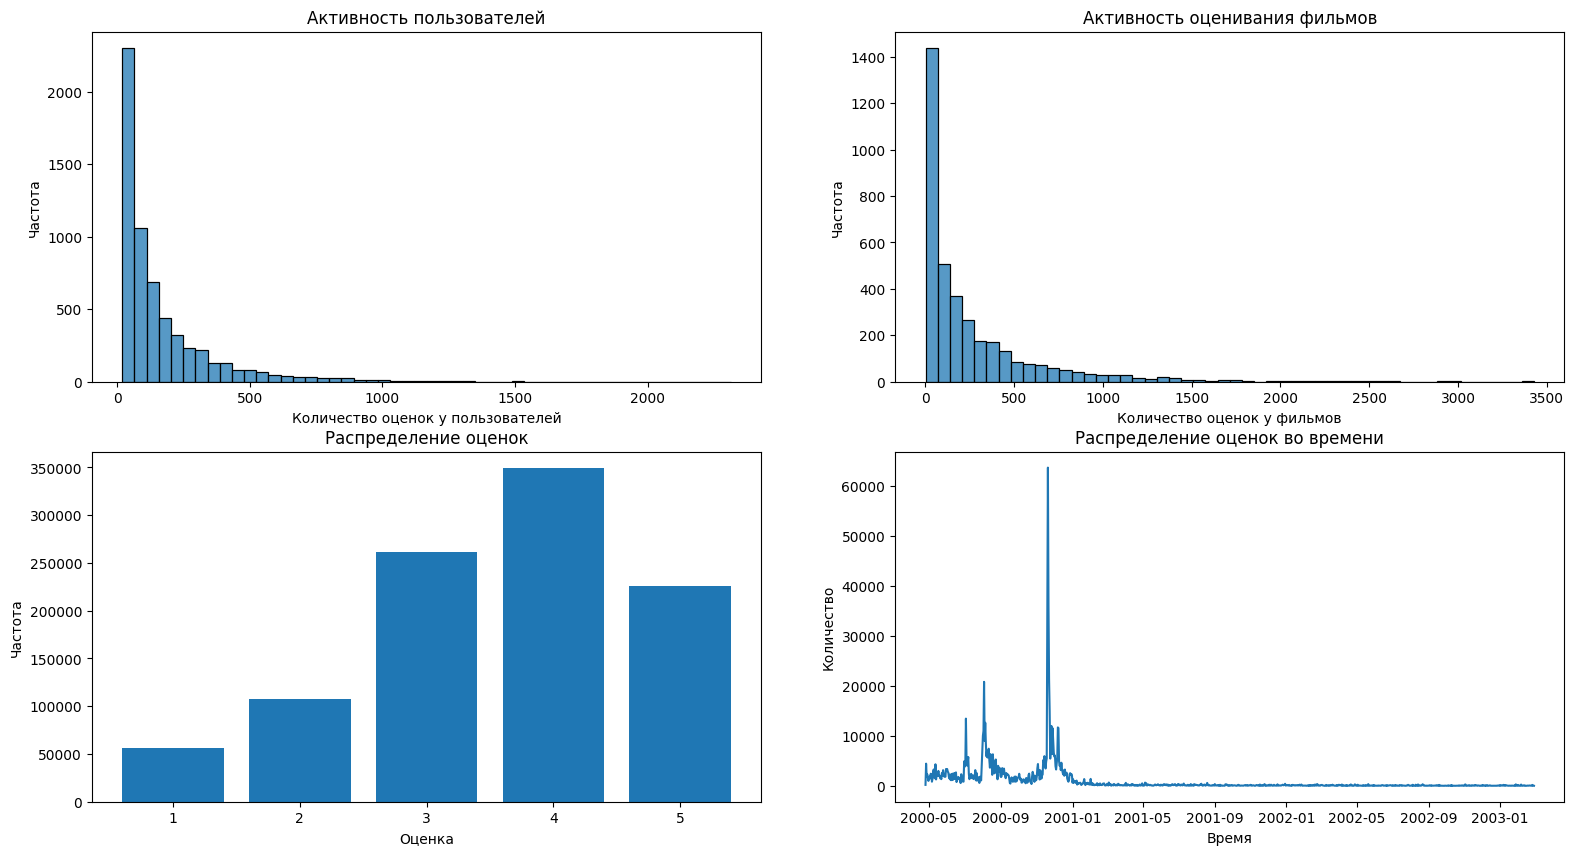

In [12]:
fig, axs = plt.subplots(2,2, figsize=(19,10))

ax = axs[0, 0]
sns.histplot(reviews.groupby('user_id').count()['item_id'], bins=50, ax=ax)
ax.set_title('Активность пользователей')
ax.set_xlabel('Количество оценок у пользователей')
ax.set_ylabel('Частота')

ax = axs[0, 1]
sns.histplot(reviews.groupby('item_id').count()['user_id'], bins=50, ax=ax)
ax.set_title('Активность оценивания фильмов')
ax.set_xlabel('Количество оценок у фильмов')
ax.set_ylabel('Частота')

ax = axs[1, 0]
ax.bar([1,2,3,4,5], reviews.groupby('relevance').count()['user_id'])
ax.set_title('Распределение оценок')
ax.set_xlabel('Оценка')
ax.set_ylabel('Частота')

ax = axs[1, 1]
reviews["date"] = reviews["timestamp"].dt.date
ax.plot(reviews.groupby("date").size().index, reviews.groupby("date").size().values)
ax.set_title('Распределение оценок во времени')
ax.set_xlabel('Время')
ax.set_ylabel('Количество')

plt.show()

Таким образом, по построенным графикам видно, что большинство пользователей ставят мало оценок на фильмы и существует множество фильмов, которые имеют всего несколько отзывов -- люди просто не хотят ставить оценки. При этом чаще всего фильмам ставят оценку 4, а реже всего -- 1. Видимо, мы работаем не с самой негативной аудиторией, но возможно для многих людей оценка 4 в этом контексте -- уже знак, что фильм не понравился. Во временной зависимости мы видим, что есть 3 пика, где много людей резко начали ставить оценки, что может быть связано просто с популярностью сервиса.

In [13]:
rpt = reviews[(reviews['date'] > pd.to_datetime('20000601').date()) & (reviews['date'] < pd.to_datetime('20010101').date())]

In [14]:
rpt.item_id.value_counts()[:15]

,count
item_id,
2858,3045
1196,2545
260,2534
1210,2480
480,2336
589,2307
2028,2297
1270,2218
1580,2207


item_id 2858 - Красота по Американски. Очень популрный фильм конца 1999 года.

In [15]:
rpt.user_id.value_counts()

,count
user_id,
4169,2029
1680,1850
889,1518
1181,1487
4277,1443
...,...
5487,1
5664,1
5668,1


Но в итоге по ощущению присутствие 3 пиков не связана с какими-то бурными новинками, а просто с популярностью самих отзывов как таковых.

In [16]:
reviews = reviews.drop('date', axis=1)

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [17]:
train = reviews[reviews["timestamp"] < pd.to_datetime("20001201")]
val = reviews[(reviews["timestamp"] >= pd.to_datetime("20001201")) & (reviews["timestamp"] <= pd.to_datetime("20001231"))]
val = val[val['relevance'] > 3]
train_users = set(train["user_id"])
val = val[val["user_id"].isin(train_users)]

In [18]:
val.shape[0]

14790

In [19]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [20]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [21]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


In [22]:
train['relevance'] = train['relevance'].astype(float)

<ipython-input-22-d0ac5a6645a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype(float)


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [23]:
%%time
np.random.seed(SEED)

unique_users = val["user_id"].unique()
unique_items = set(reviews["item_id"].unique())
watched_items_by_user = train.groupby("user_id")["item_id"].apply(set).to_dict()
recommendations = []

for user in unique_users:
    watched_items = watched_items_by_user.get(user, set())
    candidate_items = list(unique_items - watched_items)

    if len(candidate_items) < 20:
        print('Недостаточный выбор фильмов')
        sampled_items = candidate_items
    else:
        sampled_items = np.random.choice(candidate_items, 20, replace=False)

    for item in sampled_items:
        recommendations.append((user, item, np.random.choice([1, 2, 3, 4, 5])))

random_pred = pd.DataFrame(recommendations, columns=["user_id", "item_id", "relevance"])

CPU times: user 710 ms, sys: 63.9 ms, total: 774 ms
Wall time: 769 ms


In [24]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [25]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,1394,4


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [26]:
import math

In [27]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    DCG = np.sum(np.isin(row.pred_list[:k], row.gt_list) / np.log2(np.arange(min(len(row.pred_list), k)) + 2))
    IDCG = np.sum(1 / np.log2(np.arange(min(len(row.gt_list), k)) + 2))
    return DCG / IDCG if IDCG != 0 else 0


In [28]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [29]:
ngcg = 0
for user_id in random_pred['user_id'].unique():
    pred_list = random_pred[random_pred['user_id'] == user_id].item_id.to_list()
    gt_list = val[val['user_id'] == user_id].item_id.to_list()
    ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=20)
    ngcg += ngcg_oneuser
all_ngcg = ngcg / len(random_pred['user_id'].unique())

In [30]:
print(all_ngcg)

0.008849688328830123


### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [31]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        total_users = log['user_id'].nunique()
        self.information = dict(-np.log2(log.groupby("item_id").count().user_id / total_users))
        self.default_value = np.log2(total_users)

    def __call__(self, pred, k):
        surprisal = 0
        n_users_pred = pred.user_id.nunique()

        for user_id in pred.user_id.unique():
            for item_id in pred[pred.user_id == user_id].item_id[:k]:
                surprisal += self.information.get(item_id, self.default_value)

        return surprisal / (n_users_pred * k * self.default_value)

In [32]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [33]:
def coverage(pred, k, all_items=train['item_id']):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)


def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [34]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user



def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [35]:
def measure(pred, true, train, k, name, df=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@K', 'coverage@K', 'Surprisal', 'nDCG@K'])
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'coverage@K'] = coverage(pred=pred, k=k)
    df.loc[name, 'Surprisal'] = Surprisal(train)(pred, k)
    ngcg = 0
    for user_id in pred['user_id'].unique():
        pred_list = pred[pred['user_id'] == user_id].item_id.to_list()
        gt_list = true[true['user_id'] == user_id].item_id.to_list()
        ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=k)
        ngcg += ngcg_oneuser
    all_ngcg = ngcg / len(pred['user_id'].unique())
    df.loc[name, 'nDCG@K'] = all_ngcg
    return df

In [60]:
rec_data = measure(random_pred, val, train, 20, 'Baseline')
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885


Как можно увидеть, случайное предсказание рекомендует не очень качественно, но очень разнообразно. Но для хорошего сервиса, конечно, такой метод не подойдет.

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

Во всех заданиях дальше наш код будет состоять из двух частей -- предобработка данных для корректного и быстрого обучени модели и самого обучени. Саму предобработку запишем в отдельную функцию.

In [102]:
def preproc(train, val):
    user_cat = train['user_id'].astype('category')
    item_cat = train['item_id'].astype('category')
    user_ids = user_cat.cat.codes
    item_ids = item_cat.cat.codes
    user_item_matrix = csr_matrix((train['relevance'], (user_ids, item_ids)))
    val_users = val['user_id'].unique()
    user_mapping = dict(zip(user_cat.cat.categories, range(len(user_cat.cat.categories))))
    item_mapping = dict(zip(range(len(item_cat.cat.categories)), item_cat.cat.categories))
    return (user_item_matrix, val_users, user_mapping, item_mapping)

### CosineRecommender

Для начала разберемся с CosineRecommender -- построим график зависимости метрик от парметра K.

In [69]:
user_item_matrix, val_users, user_mapping, item_mapping = preproc(train, val)

In [70]:
Ks = np.concat([np.array([10, 15, 20, 25, 30]), np.arange(30, 600, 40)])
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
for K in Ks:
    model = implicit.nearest_neighbours.CosineRecommender(K=K)
    model.fit(user_item_matrix)
    recommendations = []
    for user in tqdm(val_users):
        user_idx = user_mapping[user]
        recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val, train, 20, 'CosineRecommender')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005499601364135742 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 7154.45it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005261659622192383 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4742.11it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0052776336669921875 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6628.14it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005160808563232422 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2276.40it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00661158561706543 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1488.15it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008995771408081055 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3474.97it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005845785140991211 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4737.78it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0054471492767333984 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2593.32it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005936622619628906 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3480.51it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0054340362548828125 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2331.51it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005342721939086914 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2643.14it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005489826202392578 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2485.59it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005660533905029297 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1626.50it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00606846809387207 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2308.16it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005532264709472656 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2031.50it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005712747573852539 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1895.97it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005463123321533203 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1755.42it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00559687614440918 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1039.82it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006369113922119141 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1543.48it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005347490310668945 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1485.49it/s]


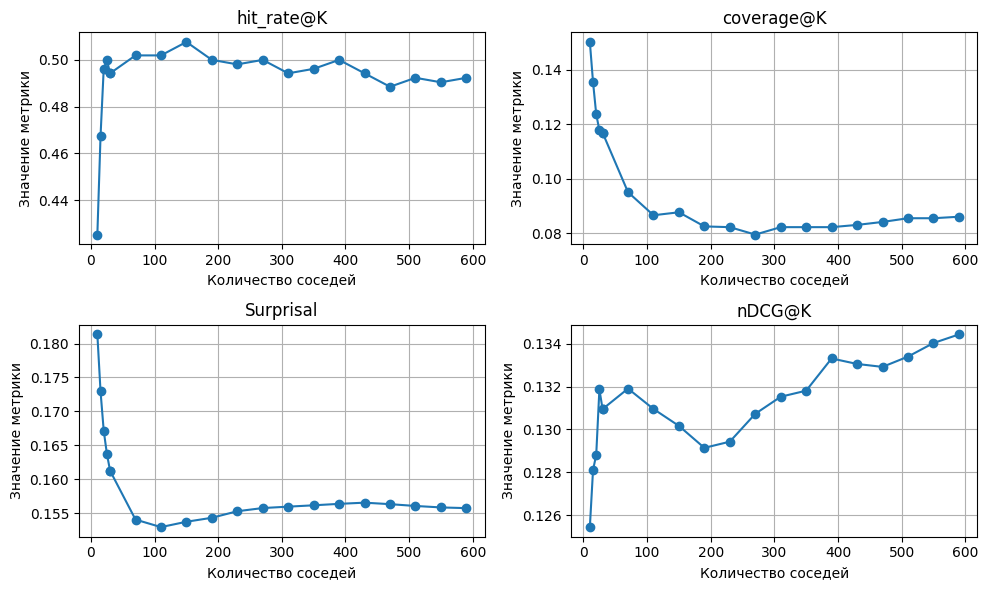

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(Ks, values, marker='o')
    ax.set_xlabel("Количество соседей")
    ax.set_ylabel("Значение метрики")
    ax.set_title(key)
    ax.grid()
plt.tight_layout()
plt.show()

In [73]:
max_K_cos = np.argmax(metrics['nDCG@K'])
cos_metrics = {'hit_rate@K' : metrics['hit_rate@K'][max_K_cos],
               'coverage@K' : metrics['coverage@K'][max_K_cos],
               'Surprisal' : metrics['Surprisal'][max_K_cos],
               'nDCG@K' : metrics['nDCG@K'][max_K_cos]}
rec_data.loc["CosineRecommender"] = cos_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443


Проанализируем полученные результаты.

С увеличением количества соседей метрики Coverage и Surprisal падают. Модель запоминает все больше соседей и диапазон подходящий для рекомендаций фильмов сужается. Метрика nDCG растет - чем больше соседей запомнила модель, тем более похожие предсказания она сделает. Метрика HitRate растет, потому что растет вариация выбора модели.

### TF-IDF

Рассматривае каждый фильма как документ, а каждого пользователя - как термин в этих документах. Идея TF-IDF: TF - частота item в данных, а IDF - логарифм обратной частоты. Таким образом, мы учитываем активных пользователей сильнее, а неизбирательных пользователей меньше.

In [74]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
user_item_matrix_tfidf, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf = preproc(train_tfidf, val_tfidf)


def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.BM25Recommender(K=K)
    model.fit(user_item_matrix_tfidf)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]
        recs = model.recommend(user_idx, user_item_matrix_tfidf[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_tfidf, 20, 'TF-IDF')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-74-719faef503a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 17:11:51,818] A new study created in memory with name: no-name-295fe004-2e22-4679-8cae-c7e6ba6337b6


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004802703857421875 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4105.46it/s]


[I 2025-03-24 17:11:53,629] Trial 0 finished with value: 0.1635949929687008 and parameters: {'K': 125}. Best is trial 0 with value: 0.1635949929687008.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00466609001159668 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3185.76it/s]


[I 2025-03-24 17:11:55,298] Trial 1 finished with value: 0.1636990092315632 and parameters: {'K': 101}. Best is trial 1 with value: 0.1636990092315632.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004969358444213867 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1385.24it/s]


[I 2025-03-24 17:11:57,685] Trial 2 finished with value: 0.16793778822668143 and parameters: {'K': 344}. Best is trial 2 with value: 0.16793778822668143.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005331993103027344 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1789.86it/s]


[I 2025-03-24 17:12:00,557] Trial 3 finished with value: 0.1671482554417742 and parameters: {'K': 486}. Best is trial 2 with value: 0.16793778822668143.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004793643951416016 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 8432.17it/s]


[I 2025-03-24 17:12:02,012] Trial 4 finished with value: 0.12388260773098948 and parameters: {'K': 2}. Best is trial 2 with value: 0.16793778822668143.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004993915557861328 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2243.04it/s]


[I 2025-03-24 17:12:04,185] Trial 5 finished with value: 0.16806760415363595 and parameters: {'K': 427}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004683732986450195 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2094.90it/s]


[I 2025-03-24 17:12:06,288] Trial 6 finished with value: 0.1665577782531421 and parameters: {'K': 369}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00494074821472168 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3989.51it/s]


[I 2025-03-24 17:12:08,059] Trial 7 finished with value: 0.16572870949062687 and parameters: {'K': 149}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00477910041809082 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2353.49it/s]


[I 2025-03-24 17:12:10,283] Trial 8 finished with value: 0.16745385422536962 and parameters: {'K': 380}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005838871002197266 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1382.83it/s]


[I 2025-03-24 17:12:13,314] Trial 9 finished with value: 0.16706621600726734 and parameters: {'K': 373}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004773855209350586 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1985.61it/s]


[I 2025-03-24 17:12:15,530] Trial 10 finished with value: 0.16741496437115028 and parameters: {'K': 499}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004857540130615234 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1573.66it/s]


[I 2025-03-24 17:12:18,449] Trial 11 finished with value: 0.1679693633670611 and parameters: {'K': 268}. Best is trial 5 with value: 0.16806760415363595.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005120754241943359 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1718.54it/s]


[I 2025-03-24 17:12:21,683] Trial 12 finished with value: 0.16808532046637933 and parameters: {'K': 250}. Best is trial 12 with value: 0.16808532046637933.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00516200065612793 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1654.37it/s]


[I 2025-03-24 17:12:25,552] Trial 13 finished with value: 0.16780769998999728 and parameters: {'K': 243}. Best is trial 12 with value: 0.16808532046637933.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005618095397949219 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1961.96it/s]


[I 2025-03-24 17:12:28,685] Trial 14 finished with value: 0.16824411059396877 and parameters: {'K': 254}. Best is trial 14 with value: 0.16824411059396877.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005369424819946289 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1442.43it/s]


[I 2025-03-24 17:12:31,939] Trial 15 finished with value: 0.16803374444984942 and parameters: {'K': 252}. Best is trial 14 with value: 0.16824411059396877.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0052225589752197266 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2711.43it/s]


[I 2025-03-24 17:12:34,345] Trial 16 finished with value: 0.16766151616278366 and parameters: {'K': 194}. Best is trial 14 with value: 0.16824411059396877.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004817008972167969 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2023.79it/s]


[I 2025-03-24 17:12:36,577] Trial 17 finished with value: 0.16785468884343271 and parameters: {'K': 312}. Best is trial 14 with value: 0.16824411059396877.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005957126617431641 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1876.60it/s]


[I 2025-03-24 17:12:39,523] Trial 18 finished with value: 0.16766151616278366 and parameters: {'K': 194}. Best is trial 14 with value: 0.16824411059396877.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0046918392181396484 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 5440.06it/s]


[I 2025-03-24 17:12:41,119] Trial 19 finished with value: 0.162102342120877 and parameters: {'K': 64}. Best is trial 14 with value: 0.16824411059396877.


In [75]:
study.best_params

{'K': 254}

In [78]:
K = study.best_params['K']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'TF-IDF')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009471654891967773 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1411.97it/s]


In [81]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.522989,0.092299,0.152305,0.133895


### TF-IDF on positive

Далее отделим все положительные метки в train.

In [117]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
train_positive = train_tfidf[train_tfidf['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf = preproc(train_positive, val_tfidf)

def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.BM25Recommender(K=K)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]

        user_interactions = train_tfidf[train_tfidf['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = set(user_interactions['item_id'].map(item_mapping_tfidf).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_positive, 20, 'TF-IDF on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-117-7063a9f026fb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 18:41:46,878] A new study created in memory with name: no-name-aa867458-2c1c-46d0-be32-047c3f0f45eb


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003072977066040039 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 137.44it/s]


[I 2025-03-24 18:41:50,873] Trial 0 finished with value: 0.15435887382798164 and parameters: {'K': 149}. Best is trial 0 with value: 0.15435887382798164.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0029273033142089844 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 96.18it/s] 


[I 2025-03-24 18:41:55,918] Trial 1 finished with value: 0.15342169458937607 and parameters: {'K': 80}. Best is trial 0 with value: 0.15435887382798164.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0030922889709472656 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


 83%|████████▎ | 305/366 [00:02<00:00, 147.15it/s]


[W 2025-03-24 18:41:58,703] Trial 2 failed with parameters: {'K': 410} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-117-7063a9f026fb>", line 25, in optimizing
    seen_items = set(user_interactions['item_id'].map(item_mapping_tfidf).values)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/series.py", line 4700, in map
    new_values = self._map_values(arg, na_action=na_action)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/base.py", line 921, in _map_values
    return algorithms.map_array(arr, mapper, na_action=na_action, convert=convert)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
study.best_params

{'K': 275}

In [84]:
K = study.best_params['K']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.BM25Recommender(K=K)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = set(user_interactions['item_id'].map(item_mapping_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0036706924438476562 seconds
  warnings.warn(


  0%|          | 0/3468 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:06<00:00, 78.23it/s]


In [85]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF on positive"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.522989,0.092299,0.152305,0.133895
TF-IDF on positive,0.722222,0.0568,0.167036,0.126113


Как мы видим, мы не улучшили нашу основную метрику nDCG@K. Возможно это связано с тем, что разбиения для валидации оказалось не таким хорошим. При это метрики, например, hit_rate@K сильно выросли, а значит мы попадаем чаще хотя бы раз.

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

### ALS

In [116]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)

user_item_matrix_als, val_users_als, user_mapping_als, item_mapping_als = preproc(train_als, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 1, 50)
    regularization = trial.suggest_float("regularization", 1e-10, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_als)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]
        recs = model.recommend(user_idx, user_item_matrix_als[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_als, 20, 'ALS')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-116-ab6a08ca8d46>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 18:38:04,776] A new study created in memory with name: no-name-dd78ee83-a233-4ada-9630-7ef047aee95a


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3701.95it/s]


[I 2025-03-24 18:38:17,092] Trial 0 finished with value: 0.12213374183952207 and parameters: {'factors': 45, 'regularization': 1.4857633999029293e-10}. Best is trial 0 with value: 0.12213374183952207.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2588.82it/s]


[I 2025-03-24 18:38:23,090] Trial 1 finished with value: 0.14229178210391805 and parameters: {'factors': 15, 'regularization': 0.00344384260004271}. Best is trial 1 with value: 0.14229178210391805.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3673.26it/s]


[I 2025-03-24 18:38:31,796] Trial 2 finished with value: 0.138525047479908 and parameters: {'factors': 23, 'regularization': 3.8693076608875334e-09}. Best is trial 1 with value: 0.14229178210391805.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3505.86it/s]


[I 2025-03-24 18:38:42,000] Trial 3 finished with value: 0.12098881770857392 and parameters: {'factors': 49, 'regularization': 2.4859460985264685e-10}. Best is trial 1 with value: 0.14229178210391805.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1882.74it/s]


[I 2025-03-24 18:38:51,539] Trial 4 finished with value: 0.11964373225721502 and parameters: {'factors': 44, 'regularization': 0.08630254026254083}. Best is trial 1 with value: 0.14229178210391805.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4811.03it/s]


[I 2025-03-24 18:38:57,001] Trial 5 finished with value: 0.14706384779435394 and parameters: {'factors': 11, 'regularization': 0.008203337629396925}. Best is trial 5 with value: 0.14706384779435394.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3781.33it/s]


[I 2025-03-24 18:39:06,964] Trial 6 finished with value: 0.12372327523733406 and parameters: {'factors': 49, 'regularization': 7.876333078992978e-05}. Best is trial 5 with value: 0.14706384779435394.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1785.91it/s]


[I 2025-03-24 18:39:16,800] Trial 7 finished with value: 0.1418903442156209 and parameters: {'factors': 20, 'regularization': 3.300151015883544e-09}. Best is trial 5 with value: 0.14706384779435394.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4047.20it/s]


[I 2025-03-24 18:39:26,659] Trial 8 finished with value: 0.12051802414168357 and parameters: {'factors': 48, 'regularization': 2.8544370989941154e-06}. Best is trial 5 with value: 0.14706384779435394.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1551.32it/s]


[I 2025-03-24 18:39:45,245] Trial 9 finished with value: 0.1377331913707612 and parameters: {'factors': 26, 'regularization': 0.02121025339427429}. Best is trial 5 with value: 0.14706384779435394.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4823.76it/s]


[I 2025-03-24 18:39:48,048] Trial 10 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 8.34473143365664e-06}. Best is trial 10 with value: 0.16411128677881365.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2974.73it/s]


[I 2025-03-24 18:39:50,309] Trial 11 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 1.26823497761815e-05}. Best is trial 10 with value: 0.16411128677881365.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2407.67it/s]


[I 2025-03-24 18:39:55,994] Trial 12 finished with value: 0.17082826945676022 and parameters: {'factors': 2, 'regularization': 2.0226260462670205e-06}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1257.20it/s]


[I 2025-03-24 18:40:01,492] Trial 13 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 1.0567788741384377e-07}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2073.31it/s]


[I 2025-03-24 18:40:08,705] Trial 14 finished with value: 0.14938752991666895 and parameters: {'factors': 8, 'regularization': 0.00025761809289176414}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2300.80it/s]


[I 2025-03-24 18:40:22,788] Trial 15 finished with value: 0.1260375692204517 and parameters: {'factors': 31, 'regularization': 1.296840297006808e-06}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2219.44it/s]


[I 2025-03-24 18:40:28,588] Trial 16 finished with value: 0.15492555703609032 and parameters: {'factors': 7, 'regularization': 9.69468577929538e-07}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2303.44it/s]


[I 2025-03-24 18:40:39,536] Trial 17 finished with value: 0.12425636146978546 and parameters: {'factors': 36, 'regularization': 8.313573587050626e-08}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2865.68it/s]


[I 2025-03-24 18:40:50,127] Trial 18 finished with value: 0.14404215782771532 and parameters: {'factors': 16, 'regularization': 0.00027552098398457087}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1233.41it/s]


[I 2025-03-24 18:40:56,790] Trial 19 finished with value: 0.15218212017850513 and parameters: {'factors': 5, 'regularization': 1.215592362849501e-07}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2016.63it/s]


[I 2025-03-24 18:41:05,606] Trial 20 finished with value: 0.14452027768274572 and parameters: {'factors': 13, 'regularization': 1.5344082775047346e-05}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1100.64it/s]


[I 2025-03-24 18:41:10,763] Trial 21 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 2.052684874539203e-05}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2339.87it/s]


[I 2025-03-24 18:41:19,606] Trial 22 finished with value: 0.1649562884584695 and parameters: {'factors': 4, 'regularization': 2.3157446741763637e-05}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2233.12it/s]


[I 2025-03-24 18:41:26,009] Trial 23 finished with value: 0.1528732189849413 and parameters: {'factors': 6, 'regularization': 0.0013798640116540737}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2321.46it/s]


[I 2025-03-24 18:41:34,532] Trial 24 finished with value: 0.15168935342257148 and parameters: {'factors': 10, 'regularization': 5.199806595444064e-07}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2404.57it/s]


[I 2025-03-24 18:41:40,193] Trial 25 finished with value: 0.1652359822336837 and parameters: {'factors': 4, 'regularization': 7.61339091262617e-05}. Best is trial 12 with value: 0.17082826945676022.


  0%|          | 0/15 [00:00<?, ?it/s]

[W 2025-03-24 18:41:40,596] Trial 26 failed with parameters: {'factors': 18, 'regularization': 9.726317504854048e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-116-ab6a08ca8d46>", line 16, in optimizing
    model.fit(user_item_matrix_als)
  File "/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py", line 170, in fit
    solver(
  File "_als.pyx", line 148, in implicit.cpu._als.least_squares_cg
  File "_als.pyx", line 164, in implicit.cpu._als._least_squares_cg
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/_twodim_base_impl.py", line 159, in eye
    @set_array_function_like_doc
    
KeyboardInterrupt
[W 2025-03-24 18:41:40,599] Trial 26 failed with value None.


KeyboardInterrupt: 

In [89]:
study.best_params

{'factors': 3, 'regularization': 0.030806619344149293}

In [90]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'ALS')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3963.41it/s]


In [91]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS"] = ALS_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.522989,0.092299,0.152305,0.133895
TF-IDF on positive,0.722222,0.0568,0.167036,0.126113
ALS,0.551724,0.111415,0.150429,0.148171


### ALS on positive

In [120]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)
train_positive = train_als[train_als['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_als, user_mapping_als, item_mapping_als = preproc(train_positive, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 5, 50)
    regularization = trial.suggest_float("regularization", 1e-6, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]

        user_interactions = train_als[train_als['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = list(user_interactions['item_id'].map(item_mapping_als).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_positive, 20, 'ALS on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-120-2bb841a4f5c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 18:43:22,778] A new study created in memory with name: no-name-72c8d38a-7c5a-407e-9881-c4d1383ff40c


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/366 [00:00<?, ?it/s]


[W 2025-03-24 18:43:27,115] Trial 0 failed with parameters: {'factors': 34, 'regularization': 0.009054659645396498} because of the following error: IndexError('only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-120-2bb841a4f5c3>", line 28, in optimizing
    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/implicit/cpu/matrix_factorization_base.py", line 79, in recommend
    ids, scores = topk(
                  ^^^^^
  File "topk.pyx", line 32, in implicit.cpu.topk.topk
  File "topk.pyx", line 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
study.best_params

In [ ]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = set(user_interactions['item_id'].map(item_mapping_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

In [ ]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS on positive"] = ALS_metrics
rec_data

# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Посмотрим на распределение метрик.

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(21, 4.5))

for ax, metrics in zip(axs.ravel(), rec_data.columns):
    sns.barplot(rec_data[metrics], ax=ax)
    ax.set_title(metrics)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelrotation=60)

plt.tight_layout()